In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import pickle
import feather
import tensorflow as tf

from keras.layers import Input, Embedding, LSTM, Dense, merge
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.layers import Convolution1D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers import Embedding
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.visualize_util import plot
from keras.utils.visualize_util import model_to_dot
from keras.preprocessing import text
from keras.preprocessing import sequence

from keras_tqdm import TQDMNotebookCallback

from sklearn import metrics

In [9]:
def MapInterestToVector(interest_level):
    if interest_level == 'low':
        return [1,0,0]
    elif interest_level == 'medium':
        return [0,1,0]
    elif interest_level == 'high':
        return [0,0,1]
    else:
        return [0,0,0]

In [24]:
#training_frame = pickle.load( open( '../../Data/RentalListingData/training_set_with_images_and_features.pkl', 'rb' ) )
training_frame = feather.read_dataframe(path='../../Data/RentalListingData/first_dataframe_train_with_feature_clusters_and_xgb_preds')
training_frame['interest_vector'] = training_frame['interest_level'].apply(MapInterestToVector)

In [25]:
training_xgb_out = np.array([MapInterestToVector(item) for item in list(training_frame['predictions'].apply(str))]).astype(float)

In [30]:
training_frame.ix[:,1:20].head(2)

,bathrooms,bedrooms,building_id,description,display_address,features,latitude,longitude,listing_id,manager_id,price,street_address,photos,interest_level,Var.16,lounge,parking,convbedroom,spaciouslayout
0,1.0,1.0,8579a0b0d54db803821a35a4a615e97a,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"0 [Dining Room, Pre-War, Laundry in Bui...",40.7108,-73.9539,7170325.0,a10db4590843d78c784171a107bdacb4,2400.0,145 Borinquen Place,0 [https://photos.renthop.com/2/7170325...,medium,0.0,0.0,0.0,0.0,0.0
1,1.0,2.0,b8e75fc949a6cd8225b455648a951712,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"0 [Dining Room, Pre-War, Laundry in Bui...",40.7513,-73.9722,7092344.0,955db33477af4f40004820b4aed804a0,3800.0,230 East 44th,0 [https://photos.renthop.com/2/7170325...,low,0.0,0.0,0.0,0.0,0.0


In [45]:
training_x = np.array(training_frame.ix[:,[1,2,7,8,11]+list(range(15,876))]).astype(float)

In [49]:
np.shape(training_x)

(49352, 866)

In [46]:
training_y = list(training_frame['interest_vector'])
training_y = np.array(training_y).astype(float)

In [47]:
max_features = 4000
maxlen = 250
batch_size = 32
embedding_dims = 60
nb_filter = 250
filter_length = 3
hidden_dims = 250
nb_epoch = 2

In [73]:
model = Sequential()

# model.add(Embedding(max_features,
#                     embedding_dims,
#                     input_length=maxlen,
#                     dropout=0.1))

model.add(Dense(250, batch_input_shape=(None, 866)))
model.add(Dropout(0.2))
model.add(Activation('sigmoid'))

model.add(Dense(120))
model.add(Dropout(0.2))
model.add(Activation('tanh'))

model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [74]:
nb_epoch = 10
batch_size = 32

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')   
history = LossHistory()

In [75]:
#training_xgb_out
#training_y
model.fit(training_x, training_xgb_out, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.15, verbose=0, shuffle=True, callbacks=[TQDMNotebookCallback(leave_inner = True, leave_outer = True), history])

208/|/[loss: 0.034, acc: 0.995]  16%|| 208/1311 [00:11<00:03, 294.37it/s]                                              

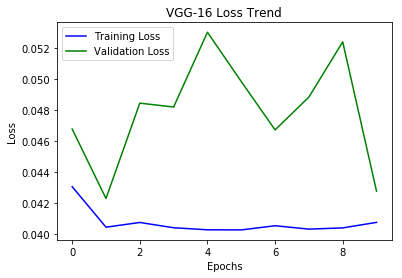

In [76]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [77]:
predictions = model.predict(training_x, verbose=0)

In [83]:
indx = 0

for i in np.random.randint(0,1900,15):
    if predictions[i][0] >= 0.5: 
        print('I am {:.2%} sure this property yields low interest'.format(predictions[i][0]))
        #print('The price on this property is ${0} per month'.format(training_aux_clean[i][0]))
        if list(training_y[i]) == [1,0,0]:
            print('I was right!')
        else:
            print('I was wrong ')
        print(i)
    elif predictions[i][1] >= 0.5:
        print('I am {:.2%} sure this property yields medium interest'.format(predictions[i][1]))
        #print('The price on this property is ${0} per month'.format(training_aux_clean[i][0]))
        if list(training_y[i]) == [0,1,0]:
            print('I was right!')
        else:
            print('I was wrong ')
        print(i)
    elif predictions[i][2] >= 0.5:
        print('I am {:.2%} sure this propertry yields high interest'.format(predictions[i][2]))
        #print('The price on this property is ${0} per month'.format(training_aux_clean[i][0]))
        if list(training_y[i]) == [0,0,1]:
            print('I was right!')
        else:
            print('I was wrong ')
        print(i)
    else:
        print('Im not really sure what interest this property yields')
        print(i)
        
    
#     plt.imshow(training_x_clean[i])
#     plt.show()

I am 99.74% sure this property yields low interest
I was right!
684
I am 99.74% sure this property yields low interest
I was right!
402
I am 99.74% sure this property yields low interest
I was right!
42
I am 99.74% sure this property yields low interest
I was right!
1354
I am 99.74% sure this property yields low interest
I was right!
578
I am 99.74% sure this property yields low interest
I was right!
610
I am 99.74% sure this property yields low interest
I was right!
1726
I am 99.74% sure this property yields low interest
I was right!
854
I am 99.74% sure this property yields low interest
I was right!
864
I am 99.74% sure this property yields low interest
I was right!
834
I am 99.74% sure this property yields low interest
I was right!
482
I am 99.74% sure this property yields low interest
I was right!
1565
I am 99.74% sure this property yields low interest
I was right!
432
I am 99.74% sure this property yields low interest
I was right!
194
I am 99.74% sure this property yields low inte

In [84]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = metrics.roc_curve(training_y[:, i], predictions[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

C:\Users\Stoja\Anaconda3\envs\tensorflow2\lib\site-packages\sklearn\metrics\ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [85]:
roc_auc

{0: 0.500030593514175, 1: 0.43568052516965783, 2: nan}